In [1]:
%load_ext autoreload
%autoreload 2

# 4. Sobel patch picking

After all preparations in previous chapters we can create out first mosaic building
algorithm. We will focus purely on matching edges of images.

In order to work purely on Sobel descriptor, set config variables as follows:
```python
USE_SOBEL_DESCRIPTOR = True
USE_HISTOGRAM_DESCRIPTOR = False
```

We will work on two classes:
  - `Patch` from `mosaic_maker.patch.patch` module
  - `PatchPicker` from `mosaic_maker.mosaic.patch_picker` module
  
We were already working with the former one. In this section we will update it
so it creates feature vector from the Sobel picture.

The latter one is class responsible for loading and searching patches 
database. Most of its content is just loading source images. We will focus on
the `pick_patch_for` method that will handle logic of comparing different patches
and finding the best candidate.

Let's start with the descriptor.

In [2]:
import cv2
from matplotlib import pyplot as plt
from mosaic_maker.patch.patch import Patch
from config import PATCH_SIZE, PROJECT_ROOT

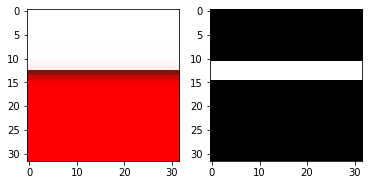

In [3]:
test_source = cv2.imread((PROJECT_ROOT / 'assets/indexed-sources/test/images/0010.jpg').as_posix())
test_source_sobel = cv2.imread(
    (PROJECT_ROOT / 'assets/indexed-sources/test/sobel-images/0010.jpg').as_posix(), 
    cv2.IMREAD_GRAYSCALE
)
_, grid = plt.subplots(1, 2)
grid[0].imshow(test_source)
grid[1].imshow(test_source_sobel, cmap='gray')

In [4]:
test_patch = Patch('test', test_source, test_source_sobel)
test_patch._calculate_features()

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

As you can see, currently patch is not calculating any features. Let's change
`_calculate_features` method part running when `USE_SOBEL_DESCRIPTOR` is set 
to `True`.

Our descriptor will be pretty simple: as Sobel images are already described by
one value per pixes from `0-255` range, we will just use Sobel image itself
as a descriptor. We will just have to flatten it to one dimentional array and 
normalize to make it better suited descriptor for future processing.

You will need [`flatten`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.flatten.html)
function from `Numpy` and [`normalize`](https://docs.opencv.org/master/d2/de8/group__core__array.html#ga87eef7ee3970f86906d69a92cbf064bd)
from `OpenCV`.

After calculating vector, append result set to the features array.

**Sidenote** you could also normalize vector using cool `Numpy` algebraic
operators. 


In [5]:
test_patch._calculate_features()

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [6]:
test_patch._calculate_features()[test_patch._calculate_features() > 0]

array([0.08838835, 0.08838835, 0.08838835, 0.08838835, 0.08838835,
       0.08838835, 0.08838835, 0.08838835, 0.08838835, 0.08838835,
       0.08838835, 0.08838835, 0.08838835, 0.08838835, 0.08838835,
       0.08838835, 0.08838835, 0.08838835, 0.08838835, 0.08838835,
       0.08838835, 0.08838835, 0.08838835, 0.08838835, 0.08838835,
       0.08838835, 0.08838835, 0.08838835, 0.08838835, 0.08838835,
       0.08838835, 0.08838835, 0.08838835, 0.08838835, 0.08838835,
       0.08838835, 0.08838835, 0.08838835, 0.08838835, 0.08838835,
       0.08838835, 0.08838835, 0.08838835, 0.08838835, 0.08838835,
       0.08838835, 0.08838835, 0.08838835, 0.08838835, 0.08838835,
       0.08838835, 0.08838835, 0.08838835, 0.08838835, 0.08838835,
       0.08838835, 0.08838835, 0.08838835, 0.08838835, 0.08838835,
       0.08838835, 0.08838835, 0.08838835, 0.08838835, 0.08838835,
       0.08838835, 0.08838835, 0.08838835, 0.08838835, 0.08838835,
       0.08838835, 0.08838835, 0.08838835, 0.08838835, 0.08838

Cool. After making feature descriptor work we'll have to rerun indexing to
make `PatchPicker` work as it loads data from CSV file from `assets` directory.

In [7]:
from mosaic_maker.index_assets import index_images
from config import IMAGES_SET
index_images(IMAGES_SET, PATCH_SIZE)

PROCESSING FILES:
  > 0299.jpg  DONE


Check if generated CSV file contains feature descriptors to make sure everything
is ok.


Ok, we have descriptor now its time to match vectors. 

Matching happens in `pick_patch_for` method of `PatchPicker` class. Method has
Two parts:
  - first distances between target patch and patches from database are calculated
  - next patch with minimal distance is selected
  
Method execution varies depending on `USE_HISTOGRAM_DESCRIPTOR` and
`USE_SOBEL_DESCRIPTOR` flags values. We will focus on the case when
`USE_SOBEL_DESCRIPTOR` equals `True` and `USE_HISTOGRAM_DESCRIPTOR`
is `False`.

Patch selection in this case is pretty easy and only requires applying 
[`argmin`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.argmin.html)
in a proper way.

For distance, euclidean measure works great. You can implement it using basic
`Numpy` operators. You can use `sobel_vector_length` value to extract Sobel
part of features vector (in future it will be combined with histogram features). 

In [8]:
from mosaic_maker.mosaic.patch_picker import PatchPicker

patch_picker = PatchPicker('test', PROJECT_ROOT / 'assets/indexed-sources/test')

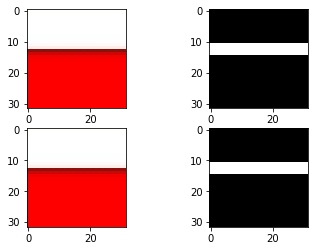

In [9]:
selected_patch = patch_picker.pick_patch_for(test_patch)
_, grid = plt.subplots(2, 2)
grid[0, 0].imshow(test_source)
grid[0, 1].imshow(test_source_sobel, cmap='gray')
grid[1, 0].imshow(selected_patch.image)
grid[1, 1].imshow(selected_patch.sobel_image, cmap='gray')

As we are targeting patch from source images directory, the Sobel picture 
match should be perfect. Colors may differ.

Let's see hot it will work for the whole mosaic. Again, Sobel image should be 
a good resemblance of the original. Pattern may be however not visible on
color image. This example shows how important information for our vision colors
provide. 

Running the next cell may take a while.

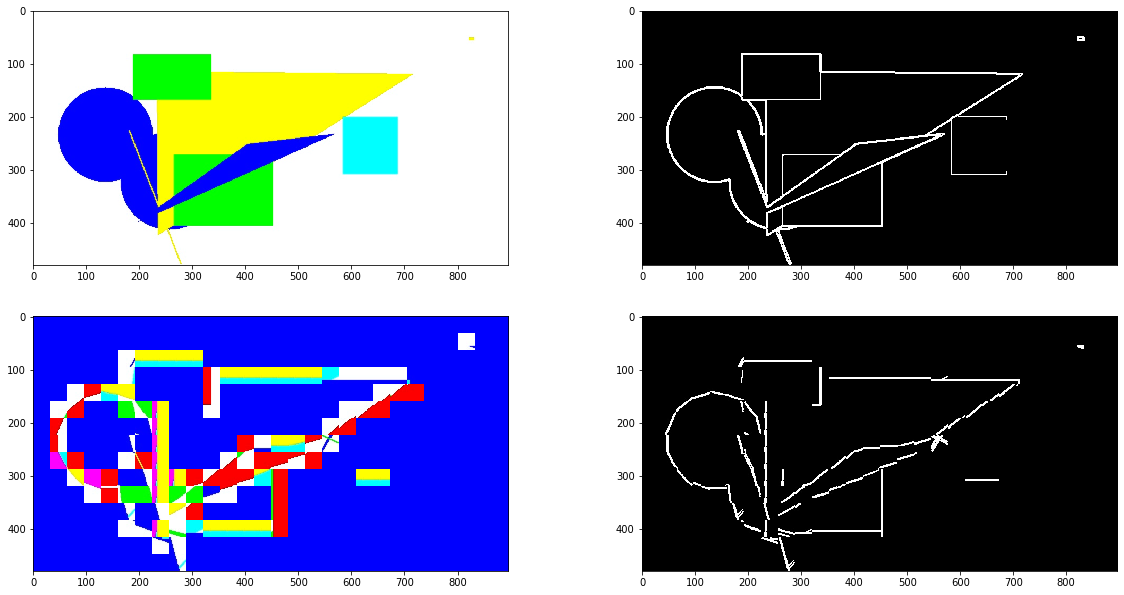

In [10]:
import numpy as np
from mosaic_maker.mosaic.mosaic_image import MosaicImage

image_path = PROJECT_ROOT / 'assets/test-target.jpg'
test_image = cv2.imread(image_path.as_posix())
mosaic_image = MosaicImage(test_image, PATCH_SIZE, patch_picker)

target_image_copy = mosaic_image.target_image.copy()
target_sobel_image_copy = mosaic_image.target_sobel_image.copy()
mosaic = np.zeros(mosaic_image.target_image.shape, np.uint8)
sobel_mosaic = np.zeros(mosaic_image.target_sobel_image.shape, np.uint8)

(height, width) = target_image_copy.shape[:2]
mosaic_image._compose_mosaic_for(width, height, 
                                 mosaic, sobel_mosaic, 
                                 target_image_copy, target_sobel_image_copy)

_, grid = plt.subplots(2, 2, figsize=(20, 10.3))
grid[0, 0].imshow(mosaic_image.target_image)
grid[0, 1].imshow(mosaic_image.target_sobel_image, cmap='gray')
grid[1, 0].imshow(mosaic)
grid[1, 1].imshow(sobel_mosaic, cmap='gray')